<a id='top'></a>

# CSCI 3202, Spring 2018
# Assignment 4
# Due:  Wednesday 21 March 2018 by 12:00 PM

<br>

### Your name:

<br>

**Note:** Some packages to load, helper functions and unit tests are defined at [the bottom of this notebook](#helpers)

Shortcuts:  [top](#top) || [1](#p1) | [1a](#p1a) | [1b](#p1b) | [1c](#p1c) | [1d](#p1d) | [1e](#p1e) | [1f](#p1f) | [1g](#p1g) || [2](#p2) | [2a](#p2a) | [2b](#p2b) | [2c](#p2c) | [2d](#p2d) | [2e](#p2e) || [3](#p3) | [3a](#p3a) | [3b](#p3b) | [3c](#p3c) | [3d](#p3d) | [3e](#p3e) || [helpers](#helpers)

**Before you begin:** You will also need to download a few data sets from the Piazza page, under the Resources tab.
1. data_sealevel.csv
1. data_temperature.csv
1. data_socks.csv

---

<a id='p1'></a>[Back to top](#top)

## Problem 1:  Calibrating a model for global mean sea level changes

<img src="http://www.anthropocenemagazine.org/wp-content/uploads/2017/05/future-sea-levels.jpg" width="250">

<a id='p1a'></a>

### (1a) Load and plot some data.

Let's load a couple data sets.  One is a data set of global mean sea levels, and the other is a data set of global mean temperatures:
* `sealevel` will be a list of global mean sea levels (millimeters)
* `sealevel_sigma` will be a list of the *uncertainty* in global mean sea levels (millimeters), and
* `temperature` will be a list of global mean temperatures (degrees Celsius).

Check to make sure (1) temperature, year and sea level time series are all the same length and period; (2) data need to be properly *normalized* against some reference period. In climate science, often the years 1961-1990 are used as the reference period.  So conduct a check to make sure that the mean sea level and mean global mean temperature for the 1961-1990 (inclusive) period are both 0.

In [18]:
year = []
sealevel = []
sealevel_sigma = []
temperature = []

dfSealevel = pd.read_csv("../../data/data_sealevel.csv")
dfTemperature = pd.read_csv("../../data/data_temperature.csv")

# We aren't doing any heavy-duty stats stuff, so let's just keep what we need as regular lists
year = dfSealevel["year"].tolist()
sealevel = dfSealevel["sealevel"].tolist()
sealevel_sigma = dfSealevel["uncertainty"].tolist()
temperature = dfTemperature["temperature"].tolist()

Plot the data points as a scatter plots, and plot them side-by-side-by-side (one row, three columns of figures). The point here is learn how to customize your figures a bit more, and also because computer screens are (typically) wider than they are tall.

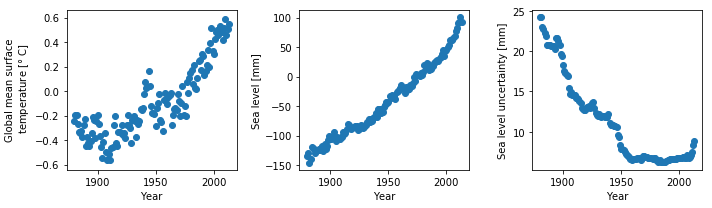

In [19]:
# Solution:

plt.subplots(1, 3, figsize=(10, 3))

plt.subplot(1, 3, 1)
plt.scatter(year, temperature)
plt.xlabel('Year')
plt.ylabel('Global mean surface\n temperature [$\degree$ C]')

plt.subplot(1, 3, 2)
plt.scatter(year, sealevel)
plt.xlabel('Year')
plt.ylabel('Sea level [mm]')

plt.subplot(1, 3, 3)
plt.scatter(year, sealevel_sigma)
plt.xlabel('Year')
plt.ylabel('Sea level uncertainty [mm]')

plt.tight_layout()
plt.show()

**Question:** How does the uncertainty in global mean sea levels change as a function of time?  When is the uncertainty the highest?  Give one reason why you think this might be the case.

**Your answer:**

uncertainty decreases as time goes on, probably because instrument accuracy improves, and data availability

<br>

<a id='p1b'></a>

### (1b)  The "out-of-box" sea-level model

In your plot from **(1a)**, you should see quite an apparent relationship between increasing temperatures and rising sea levels.  Seeems like someone should try to model the relationship between those two, huh?

In the [helper functions below](#helpers), a simple model for temperature-driven changes in global mean sea level (GMSL) is defined. This is the model of [Rahmstorf (2007)](http://science.sciencemag.org/content/315/5810/368).

The `slr` model takes two parameters, $\alpha$ and $T_{eq}$, and requires a time series of global mean temperatures: `slr(alpha, Teq, temperature)`.
* `alpha` is the sensitivity of sea-level changes to changes in global temperature. The units for $\alpha$ are millimeters of sea-level changes per year, or mm y$^{-1}$.
* `Teq` is the equilibrium global mean temperature, with units of degrees Celsius.
* `temperature` is the time series of global mean surface temperatures, assumed to be relative to the 1961-1990 mean.

For now, you do not need to worry too much about how this model works.  It is very simple, and widely used, but the point here is that you can plug in a particular set of temperatures (the model **forcing**) and parameters ($\alpha$ and $T_{eq}$), and out pops a time series of simulated global mean sea levels.

**Our goal:**  pick good values for $\alpha$ and $T_{eq}$, so that when we run the `slr` model using the observations of temperature (which we plotted above), the model output matches well the observations of global mean sea level (which we also plotted above).

The whole process of figuring out what these good parameter values are is called **model calibration**, and it's awesome.  Let's have a look at why we need to do this in the first place, shall we?

The default parameter choices given in the Rahmstorf (2007) paper are $\alpha=3.4$ mm y$^{-1}$ and $T_{eq} = -0.5\ ^{\circ}$C.

Make a plot that contains:
* the observed sea level data as scatter points
* the modeled sea levels as a line, using the temperature observations from above as the `temperature` input
* an appropriate legend and axis labels
* $x$ axis is years
* $y$ axis is sea level

Note that after you run the `slr` model, you will need to **normalize** the output relative to the 1961-1990 reference period.  That is because you are going to compare it against data that is also normalized against this reference period. The `years` that correspond to the model output should be the same as the `years` that correspond to the `temperature` input.

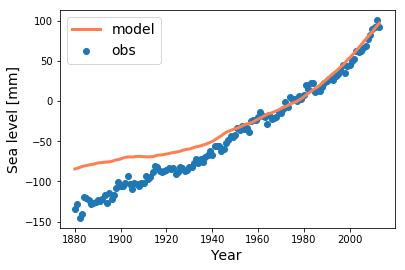

In [20]:
# Solution:

sealevel_model = slr(alpha=3.4, Teq=-0.5, temperature=temperature)

# normalize
reference = (year.index(1961), year.index(1990))
sealevel_model -= np.mean(sealevel_model[reference[0]:(reference[1]+1)])

plt.scatter(year, sealevel, label='obs')
plt.plot(year, sealevel_model, label='model', color='coral', lw=3)
plt.xlabel('Year', size=14)
plt.ylabel('Sea level [mm]', size=14)
plt.legend(fontsize=14)
plt.show()

Your plot above ought to show decent match for the late 1900s, but diverge a bit further back in time.

**The point:**  We can do better than this "out-of-the-box" version of the Rahmstorf sea level model.

<br>

<a/ id='p1c'></a>

### (1c)   Figuring out our objective function

As our **objective function**, we will use the joint likelihood function of the observed sea level data, given the model simulation.  For a single data point in year $i$, $y_i$, with associated uncertainty $\sigma_i$, we can assume the likelihood for our model simulation in year $i$, $\eta_i$, follows a normal distribution centered at the data point.  The model simulation is a **deterministic** result of our parameter choices $\alpha$ and $T_{eq}$, so we write the likelihood as:

$$L(y_i \mid \alpha, T_{eq}) = \dfrac{1}{\sqrt{2 \pi} \sigma_i} e^{-\dfrac{(\eta_i(\alpha, T_{eq}) - y_i)^2}{2\sigma_i^2}}$$

But that only uses a single data point.  Let's use all the data!  The **joint likelihood** is the product of all of the likelihoods associated with the individual data points. But that is the product of a lot of numbers that are less than 1, so it will be **tiny**.  Instead, we should try to optimize the **joint log-likelihood**, which is simply the (natural) logarithm of the joint likelihood function.

**Show** (using math) that if we assume the observational data ($y_i$) are all independent, then the joint log-likelihood is:

$$l(\mathbf{y} \mid \alpha, T_{eq}) = -\dfrac{N}{2} \log{(2\pi)} - \sum_{i=1}^N \log{(\sigma_i)} - \dfrac{1}{2}\sum_{i=1}^N \left( \dfrac{\eta_i(\alpha, T_{eq}) - y_i}{\sigma_i} \right)^2$$

where, $\mathbf{y} = [y_1, y_2, \ldots, y_N]$ is the entire vector (list) of sea level observations, $\eta(\alpha, T_{eq}) = [\eta_1(\alpha, T_{eq}), \eta_2(\alpha, T_{eq}), \ldots, \eta_N(\alpha, T_{eq})]$ is the entire vector (list) of `slr` model output when the parameter values $\alpha$ and $T_{eq}$ are used, and $N$ is the number of observations we have.

**Note:** Yes, I'm mixing the typical indexing of $1-N$ with what you'll need to implement, which is the Pythonic $0-(N-1)$. Keep this in mind as you code.

In [21]:
# Show using nice LateX/Markdown formatting...

**Solution:**

$\begin{align*}
L(y_i \mid \alpha, T_{eq}) &= \dfrac{1}{\sqrt{2 \pi} \sigma_i} e^{-\dfrac{(\eta_i(\alpha, T_{eq}) - y_i)^2}{2\sigma_i^2}} \\
L(\mathbf{y} \mid \alpha, T_{eq}) &= \prod_{i=1}^N \dfrac{1}{\sqrt{2 \pi} \sigma_i} e^{-\dfrac{(\eta_i(\alpha, T_{eq}) - y_i)^2}{2\sigma_i^2}} \\
l(\mathbf{y} \mid \alpha, T_{eq} \log{L(\mathbf{y} \mid \alpha, T_{eq})} &= \log{\left(\prod_{i=1}^N \dfrac{1}{\sqrt{2 \pi} \sigma_i} e^{-\dfrac{(\eta_i(\alpha, T_{eq}) - y_i)^2}{2\sigma_i^2}}\right)} \\
  &= \sum_{i=1}^N \log{\left(\dfrac{1}{\sqrt{2 \pi} \sigma_i} e^{-\dfrac{(\eta_i(\alpha, T_{eq}) - y_i)^2}{2\sigma_i^2}}\right)} \\
  &= \sum_{i=1}^N \left[\log{\left(\dfrac{1}{\sqrt{2 \pi} \sigma_i}\right)} + \log{\left( e^{-\dfrac{(\eta_i(\alpha, T_{eq}) - y_i)^2}{2\sigma_i^2}}\right)}\right] \\
  &= \sum_{i=1}^N \log{\left(\dfrac{1}{\sqrt{2 \pi} \sigma_i}\right)} + \sum_{i=1}^N \log{\left( e^{-\dfrac{(\eta_i(\alpha, T_{eq}) - y_i)^2}{2\sigma_i^2}}\right)} \\
  &= \sum_{i=1}^N \left(\log{1}-\log{\sqrt{2 \pi} \sigma_i}\right) + \sum_{i=1}^N \left(-\dfrac{(\eta_i(\alpha, T_{eq}) - y_i)^2}{2\sigma_i^2}\right) \log{e} \\
  &= \sum_{i=1}^N \left(-\log{\sqrt{2 \pi}} - \log{\sigma_i}\right) - \dfrac{1}{2} \sum_{i=1}^N \left(\dfrac{\eta_i(\alpha, T_{eq}) - y_i}{\sigma_i}\right)^2 \\
  &= \sum_{i=1}^N (-\log{(2 \pi)^{1/2}}) - \sum_{i=1}^N \log{\sigma_i} - \dfrac{1}{2} \sum_{i=1}^N \left(\dfrac{\eta_i(\alpha, T_{eq}) - y_i}{\sigma_i}\right)^2 \\
  &= (-\log{(2 \pi)^{1/2}}) \sum_{i=1}^N 1 - \sum_{i=1}^N \log{\sigma_i} - \dfrac{1}{2} \sum_{i=1}^N \left(\dfrac{\eta_i(\alpha, T_{eq}) - y_i}{\sigma_i}\right)^2 \\
  &= -\dfrac{1}{2} \log{(2 \pi)}\cdot N - \sum_{i=1}^N \log{\sigma_i} - \dfrac{1}{2} \sum_{i=1}^N \left(\dfrac{\eta_i(\alpha, T_{eq}) - y_i}{\sigma_i}\right)^2 \\
\end{align*}$

<br>

<a/ id='p1d'></a>

### (1d)   Defining our objective function

Now define a `log_likelihood(parameters, obs_mu, obs_sigma)` function:
* `parameters`: argument that is a list of two parameter values, $[\alpha, T_{eq}]$
  * within the likelihood function, you will need to generate the model simulation $\eta(\alpha, T_{eq})$ using the input `parameters`, for comparison against the observational data
* `obs_temp`: argument that is a time series (list) of observed global mean temperatures, that will be used to run the `slr` model. Provide a default value of `temperature` for this, because we only have one temperature data set to use, and we don't want to keep 
* `obs_mu`: argument that is a time series (list) of observed values, that will be used for comparison against the `model` output. Provide a default value of `sealevel` here, because we won't be changing the observational data.
* `obs_sigma`: argument that is a time series (list) of the corresponding uncertainties in the observational data. Simiarly, provide a default value of `sealevel_sigma` here, so we can avoid the tedious task of sending the data set into this function.
* all three of these inputs should be lists, and should be the same length
* this routine should return a **single** float number, that is the joint log-likelihood of the given `model` simulation.

You may find the `scipy.stats` package to be useful here, or you can calculate this straight from the equation above.

In [22]:
# Solution:

def log_likelihood(parameters, obs_temp=temperature, obs_mu=sealevel, obs_sigma=sealevel_sigma):
    model = slr(alpha=parameters[0], Teq=parameters[1], temperature=temperature)
    
    # normalize
    reference = (year.index(1961), year.index(1990))
    model -= np.mean(model[reference[0]:(reference[1]+1)])

    return np.sum([np.log(stats.norm.pdf(x=model, loc=obs_mu, scale=obs_sigma))])

<br>

<a/ id='p1e'></a>

### (1e)  Playing with our shiny new objective function!

Armed with our **log-likelihood** objective function, let's see what it looks like for various values of $\alpha$, while keeping $T_{eq}$ fixed at its default value ($T_{eq}=-0.5$). Try a variety of $\alpha$ values. Use a wide enough range that you can tell what the behavior of the $\alpha$-log-likelihood relationship is from a plot of the two (below).

Then, make a plot of the resulting log-likelihood values, as a function of the values for the $\alpha$ parameter used. Label your axes appropriately, and write a sentence or two commenting on the results.  What do you think is the best value for $\alpha$ (so far)?

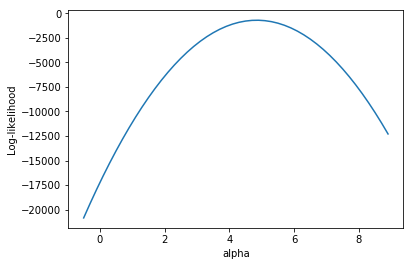

In [34]:
# Solution:

alpha_test = np.arange(-0.5, 9,.2)
ll_test = [log_likelihood(parameters=[ai, -0.5]) for ai in alpha_test]

plt.plot(alpha_test, ll_test)
plt.xlabel('alpha')
plt.ylabel('Log-likelihood')
plt.show()

Now explore a range of values around the default of $T_{eq}= -0.5 ^{\circ}$C, while keeping the $\alpha$ parameter constant at its default of 3.4 mm y$^{-1}$. Generate a plot of some test values of $T_{eq}$ against the resulting log-likelihood function values.  Label your axes.

Write a sentence or two interpreting the results.  If you had to pick optimal $\alpha$ and $T_{eq}$ values based only on these plots, what values would you use?

/Users/tony/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


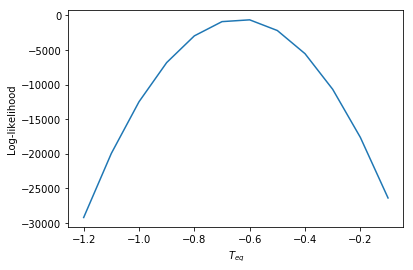

In [31]:
# Solution:

Teq_test = np.arange(-5, 5, .1)
ll_test = [log_likelihood(parameters=np.array([3.4, ti])) for ti in Teq_test]

plt.plot(Teq_test, ll_test)
plt.xlabel('$T_{eq}$')
plt.ylabel('Log-likelihood')
plt.show()

**Reflection 1:** How *likely* do values of $\alpha < 0$  or $T_{eq} > 0$ appear to be?  If these values are implausible, what does that mean in terms of the sea level-temperature system that we are modeling?

**Reflection 2:** Based on your plots above, do you think one of hill-climbing or simulated annealing will work better than the other to find the global maximum in the objective function, or does it appear that either will find the optimum?

<br>

<a/ id='p1f'></a>

### (1f)  Defining our class structure

That exploration was a nice way to get a sense of how the $\alpha$ and $T_{eq}$ parameters affect the quality of the model output, but it was not particularly rigorous. Let's apply our **hill-climbing** algorithm to this problem.

Using our in-class activity as a guide, do the following:

* Define a `State` class, with attributes for the parameter values (which define the state) and the objective function value of that state.
* Define a `Problem_hillclimb` **sub-class** of the more general class `Problem`, with:
  * attributes for the current `State` (a `State` object), the `objective_function` (the log-likelihood defined above), and `stepsize`. You will need to play around to decide what an appropriate stepsize is. Keep in mind that you may need a different stepsize for each of $\alpha$ and $T_{eq}$.
  * methods for `moves` (return the list of all possible moves from the current state) and `best_move` (return the move that maximizes the objective function).
  * the `moves` available should be in proper 2-dimensional space.  Do **not** simply optimize one parameter, keeping the other fixed, then optimize the other parameter, while keeping the first fixed.  (*That method *can* work, but there are some theoretical issues that would need to be tackled, and we are not getting into that here.*) You are allowed to restrict yourself to movements along a grid, as long as you entertain steps in both the $\alpha$ and the $T_{eq}$ directions.
* Define the `hill_climb` algorithm, with any necessary modifications (here, and in the above classes) for the new 2-dimensional state space.
  * `hill_climb(problem, n_iter)`:  arguments are a `Problem_hillclimb` object and number of iterations, `n_iter`
  * return a `State` that corresponds to the algorithm's guess at a global maximum

Subject to the above constraints, you may implement these however you would like. **If you do not use a sub-class (properly), you will lose points.** 

In [42]:
# Solution:

class State:

    def __init__(self, node, value):
        self.node = node
        self.value = value    
        
class Problem:
    
    def __init__(self, initial, objective_function, stepsize):
        self.initial_state = initial
        self.current_state = initial
        self.objective_function = objective_function
        self.stepsize = stepsize

        
def hill_climb(problem, n_iter):
    
    # iterate until we can't do any better
    for k in range(n_iter):
        nextMove, nextValue = problem.best_move()
        if nextValue <= problem.current_state.value:
            return problem.current_state
        #print(problem.current_state, nextMove)
        problem.current_state.node, problem.current_state.value = nextMove, nextValue
    print('reached n_iter')
    return False

class Problem_hillclimb(Problem):
    
    def moves(self):
        '''return all possible moves to make from the current_state'''
        all_moves = []
        # could move in +alpha direction...
        current = np.array(self.current_state.node)
        steps   = np.array(self.stepsize)
        all_moves.append(current + steps*np.array([1,0]))
        # ... or -alpha
        all_moves.append(current - steps*np.array([1,0]))
        # ... or +Teq
        all_moves.append(current + steps*np.array([0,1]))
        # ... or -Teq
        all_moves.append(current - steps*np.array([0,1]))
        return all_moves

    def best_move(self):
        '''return the best move possible from the current_state'''
        # what moves are possible?
        all_moves = self.moves()
        # what is objective function for each of them?
        obj_func = [self.objective_function(move) for move in all_moves]
        best = all_moves[max(zip(obj_func, range(len(obj_func))))[1]]
        return best, np.max(obj_func)

Now:
1. define an initial state object, using the default values from Rahmstorf 2007 as a starting point.
2. define a hill-climbing problem object, using this initial state, the log-likelihood objective function, and stepsize(s) of your choosing. (The stepsize(s) may require some playing around to find something you are happy with.)
3. ***hill-climb!!!*** Use a number of iterations that you deem appropriate. 

Play around until you have a simulation that you are happy with.  Then:
1. Print to screen the parameter values and corresponding log-likelihood value.
2. Compare this calibrated log-likelihood value to the "out-of-box" model (above).
3. Make a plot of:
  * the sea level observations as scatter points
  * the uncalibrated model as one line
  * the calibrated model as another line
  * include axis labels and a legend
  
**"Unit tests":**
* As a benchmark, make sure that your log-likelihood is *at least* -500.
* Your calibrated (optimized) model simulation should be going straight through the data points.
* If this isn't the case, remember to normalize your model against the 1961-1990 reference period!

[ 2.235  -0.8599] -467.621983589


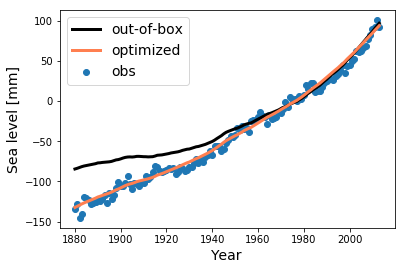

In [43]:
# Solution:

node_init = [3.4, -0.5]
obj_init = log_likelihood(node_init)
initial = State(node_init, obj_init)

problem = Problem_hillclimb(initial, log_likelihood, [.005,.0001])
hc = hill_climb(problem, 5000)
print(hc.node, hc.value)

# Control "out-of-box" simulation:
sealevel_control = slr(alpha=3.4, Teq=-0.5, temperature=temperature)
sealevel_optim   = slr(alpha=hc.node[0], Teq=hc.node[1], temperature=temperature)

# normalize
reference = (year.index(1961), year.index(1990))
sealevel_control -= np.mean(sealevel_control[reference[0]:(reference[1]+1)])
sealevel_optim   -= np.mean(sealevel_optim[reference[0]:(reference[1]+1)])

plt.scatter(year, sealevel, label='obs')
plt.plot(year, sealevel_control, label='out-of-box', color='black', lw=3)
plt.plot(year, sealevel_optim, label='optimized', color='coral', lw=3)
plt.xlabel('Year', size=14)
plt.ylabel('Sea level [mm]', size=14)
plt.legend(fontsize=14)
plt.show()

<br>

<a/ id='p1g'></a>

### (1g)  Simulated annealing

Let's re-calibrate the `slr` model. This time, we will use **simulated annealing**. Again, using our in-class activity as a guide, do the following:

* Continue to use your `State` class above.
* Define a `Problem_annealing` sub-class of the `Problem` class, with:
  * attributes for the current `State` (a `State` object), the `objective_function` (the log-likelihood defined above), and `stepsize`. You will need to play around to decide what an appropriate stepsize is. Keep in mind that you may need a different stepsize for each of $\alpha$ and $T_{eq}$.
  * method for `random_move`, to pick a random move **by drawing from a multivariate normal distribution**.  You should use the `stepsize` attribute as the covariance (width) for this.
* Define the `simulated_annealing` algorithm, with any necessary modifications (here, and in the above classes) for the new 2-dimensional state space.
  * `simulated_annealing(problem, n_iter)`:  arguments are a `Problem_annealing` object and number of iterations, `n_iter`
  * return a `State` that corresponds to the algorithm's guess at a global maximum

Subject to the above constraints, you may implement these however you would like.

In [62]:
# Solution:

def schedule(time):
    '''some sort of mapping from time to temperature, to represent how we should be 
    "cooling off" - that is, accepting wacky solutions with lower and lower probability'''
    temperature = 10/(time+1)**.7
    return temperature

def simulated_annealing(problem, n_iter):
    
    current = problem.initial_state
    
    for t in range(n_iter):
        temperature = problem.schedule_function(t)
        nextMove, nextValue = problem.random_move()
        delta_obj = nextValue - current.value
        #print(t, problem.current_state.node, problem.current_state.value, nextMove, nextValue, delta_obj)
        if delta_obj > 0:
            # the proposed move is an improvement, so accept w.p. 1
            problem.current_state.node, problem.current_state.value = nextMove, nextValue
        else:
            # the proposed move is worse; accept with probability exp[delta_obj/T]
            p_accept = np.exp(delta_obj/temperature)
            #print(p_accept)
            accept = np.random.choice([True, False], p=[p_accept, 1-p_accept])
            if accept:
                problem.current_state.node, problem.current_state.value = nextMove, nextValue

    return problem.current_state    # iterate until we can't do any better


class Problem_annealing(Problem):
        
    def __init__(self, initial, objective_function, schedule_function, stepsize):
        self.initial_state = initial
        self.current_state = initial
        self.objective_function = objective_function
        self.schedule_function = schedule_function
        self.stepsize = stepsize
        
    def random_move(self):
        '''return a random move, possible from the current_state'''
        # pick a random step
        next_move = list(stats.multivariate_normal.rvs(self.current_state.node, self.stepsize))
        return next_move, self.objective_function(next_move)


Now:
1. define an initial state object, using the default values from Rahmstorf 2007 as a starting point.
2. define a simulated annealing problem object, using this initial state, the log-likelihood objective function, an appropriate temperature updating schedule and stepsize(s) of your choosing. (The stepsize(s) may require some playing around to find something you are happy with.)
  * note that this "temperature" is distinct from the actual physical temperature used as input to drive the `slr` model
3. ***anneal!!!*** Use a number of iterations that you deem appropriate. 

Play around until you have a simulation that you are happy with.  Then:
1. Print to screen the parameter values and corresponding log-likelihood value.
2. Compare this calibrated log-likelihood value to the "out-of-box" model (above).
3. Make a plot of:
  * the sea level observations as scatter points
  * the uncalibrated model as one line
  * the calibrated model as another line
  * include axis labels and a legend
  
**"Unit tests":**  How does your model look when you plot it against the data? If it doesn't look good, then you failed this unit test :(

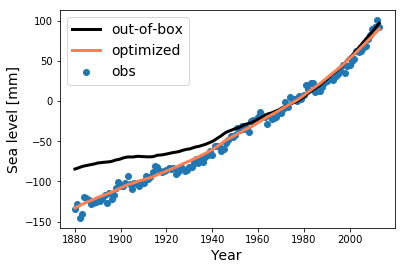

In [64]:
# Solution:

node_init = [3.4, -0.5]
obj_init = log_likelihood(node_init)
initial = State(node_init, obj_init)

problem = Problem_annealing(initial, log_likelihood, schedule, [.005,.0001])
sa = simulated_annealing(problem, 5000)
print(sa.node, sa.value)

# Control "out-of-box" simulation:
sealevel_control = slr(alpha=3.4, Teq=-0.5, temperature=temperature)
sealevel_optim   = slr(alpha=sa.node[0], Teq=sa.node[1], temperature=temperature)

# normalize
reference = (year.index(1961), year.index(1990))
sealevel_control -= np.mean(sealevel_control[reference[0]:(reference[1]+1)])
sealevel_optim   -= np.mean(sealevel_optim[reference[0]:(reference[1]+1)])

plt.scatter(year, sealevel, label='obs')
plt.plot(year, sealevel_control, label='out-of-box', color='black', lw=3)
plt.plot(year, sealevel_optim, label='optimized', color='coral', lw=3)
plt.xlabel('Year', size=14)
plt.ylabel('Sea level [mm]', size=14)
plt.legend(fontsize=14)
plt.show()

<br>

<a/ id='p1h'></a>

### (1h)  Wrap-up

Consider the values you would choose for $\alpha$ and $T_{eq}$ by only considering their **marginal** effects on the log-likelihood objective function (i.e., your answer to **1e**).  How do those compare to the values for $\alpha$ and $T_{eq}$ that you found above using simulated annealing?

The difference is that simulated annealing was considering changes in both parameters simultaneously. That is, the more sophisticated approach accounted for correlations between the parameters. This led to a better fit of the model to the data. Yay!

<br>

---

<br>

<a id='p2'></a>[Back to top](#top)

## Problem 2:  Playing "intelligent" Tic-Tac-Toe

<img src="https://www.cookieshq.co.uk/images/2016/06/01/tic-tac-toe.png" width="150"/>

<a id='p2a'></a>

### (2a)   Defining the Tic-Tac-Toe class structure

Fill in this class structure for Tic-Tac-Toe using what we did during class as a guide.
* `moves` is a list of tuples to represent which moves are available. Recall that we are using matrix notation for this, where the upper-left corner of the board, for example, is represented at (1,1).
* `result(self, move, state)` returns a ***hypothetical*** resulting `State` object if `move` is made when the game is in the current `state`
* `compute_utility(self, move, state)` calculates the utility of `state` that would result if `move` is made when the game is in the current `state`. This is where you want to check to see if anyone has gotten `nwin` in a row
* `game_over(self, state)` - this wasn't a method, but it should be - it's a piece of code we need to execute repeatedly and giving it a name makes clear what task the piece of code performs. Returns `True` if the game in the given `state` has reached a terminal state, and `False` otherwise.
* `utility(self, state, player)` also wasn't a method earlier, but also should be.  Returns the utility of the current state if the player is X and $-1 \cdot$ utility if the player is O.
* `display(self)` is a method to display the current game `state`, You get it for free! because this would be super frustrating without it.
* `play_game(self, player1, player2)` returns an integer that is the utility of the outcome of the game (+1 if X wins, 0 if draw, -1 if O wins). `player1` and `player2` are functional arguments that we will deal with in parts **2b** and **2d**.

Some notes:
* Assume X always goes first.
* Do **not** hard-code for 3x3 boards.
* You may add attributes and methods to these classes as needed for this problem.

In [2]:
class State:
    def __init__(self, moves):
        self.to_move = 'X'
        self.utility = 0
        self.board = {}
        self.moves = cp.copy(moves)

        
class TicTacToe:
    
    def __init__(self, nrow=3, ncol=3, nwin=3, nexp=0):
        self.nrow = nrow
        self.ncol = ncol
        self.nwin = nwin
#        moves = # insert your general list of nrow x ncol moves here
        moves = [(row, col) for row in range(1, nrow + 1) for col in range(1, ncol + 1)]
        self.state = State(moves)
        self.nexp = nexp

    def result(self, move, state):
        '''
        What is the hypothetical result of move `move` in state `state` ?
        move  = (row, col) tuple where player will put their mark (X or O)
        state = a `State` object, to represent whose turn it is and form
                the basis for generating a **hypothetical** updated state
                that will result from making the given `move`
        '''

        # your code goes here
        
        # Solution:
        # Don't do anything if the move isn't a legal one
        if move not in state.moves:
            return state
        # Return a copy of the updated state:
        #   compute utility, update the board, remove the move, update whose turn
        new_state = cp.deepcopy(state)
        new_state.utility = self.compute_utility(move, state)
        new_state.board[move] = state.to_move
        new_state.moves.remove(move)
        new_state.to_move = ('O' if state.to_move == 'X' else 'X')
        return new_state

        
    def compute_utility(self, move, state):
        '''
        What is the utility of making move `move` in state `state`?
        If 'X' wins with this move, return 1;
        if 'O' wins return -1;
        else return 0.
        '''        

        # your code goes here

        # Solution:
        row, col = move
        player = state.to_move
        
        # create a hypothetical copy of the board, with 'move' executed
        board = cp.deepcopy(state.board)
        board[move] = player

        # what are all the ways 'player' could with with 'move'?
        
        # check for row-wise win
        in_a_row = 0
        for c in range(1,self.ncol+1):
            in_a_row += board.get((row,c))==player

        # check for column-wise win
        in_a_col = 0
        for r in range(1,self.nrow+1):
            in_a_col += board.get((r,col))==player

        # check for NW->SE diagonal win
        in_a_diag1 = 0
        for r in range(row,0,-1):
            in_a_diag1 += board.get((r,col-(row-r)))==player
        for r in range(row+1,self.nrow+1):
            in_a_diag1 += board.get((r,col-(row-r)))==player

        # check for SW->NE diagonal win
        in_a_diag2 = 0
        for r in range(row,0,-1):
            in_a_diag2 += board.get((r,col+(row-r)))==player
        for r in range(row+1,self.nrow+1):
            in_a_diag2 += board.get((r,col+(row-r)))==player
        
        if self.nwin in [in_a_row, in_a_col, in_a_diag1, in_a_diag2]:
            return 1 if player=='X' else -1
        else:
            return 0
        

    def game_over(self, state):
        '''game is over if someone has won (utility!=0) or there
        are no more moves left'''

        # your code goes here
        
        # Solution:
        return state.utility!=0 or len(state.moves)==0    

    
    def utility(self, state, player):
        '''Return the value to player; 1 for win, -1 for loss, 0 otherwise.'''

        # your code goes here
        
        # Solution:
        return state.utility if player=='X' else -state.utility        
        
        
    def display(self):
        for row in range(1, self.nrow+1):
            for col in range(1, self.ncol+1):
                print(self.state.board.get((row, col), '.'), end=' ')
            print()
        
    def play_game(self, player1, player2):
        '''Play a game of tic-tac-toe!'''

        # your code goes here

        # Solution:
        turn_limit = self.nrow*self.ncol  # limit in case of buggy code
        turn = 0
        while turn<=turn_limit:
            for player in [player1, player2]:
                turn += 1
                move = player(self)
                self.state = self.result(move, self.state)
                if self.game_over(self.state):
                    #self.display()
                    return self.state.utility                


<br>

<a/ id='p2b'></a>

### (2b) Define a random player

Define a function `random_player` that takes a single argument of the `TicTacToe` class and returns a random move out of the available legal moves in the `state` of the `TicTacToe` game.

In your code for the `play_game` method above, make sure that `random_player` could be a viable input for the `player1` and/or `player2` arguments.

In [3]:
def random_player(game):
    '''A player that chooses a legal move at random out of all
    available legal moves in Tic-Tac-Toe state argument'''

    
    # your code goes here...

    # Solution:
    possible_actions = game.state.moves
    random_move = possible_actions[np.random.randint(low=0, high=len(possible_actions))]
    
    return random_move

We know from experience and/or because I'm telling you right now that if two `random_player`s play many games of Tic-Tac-Toe against one another, whoever goes first will win about 58% of the time.  Verify that this is the case by playing at least 1,000 games between two random players. Report the proportion of the games that the first player has won.

**"Unit tests":** If you are wondering how close is close enough to 58%, I simulated 100 tournaments of 1,000 games each. The min-max range of win percentage by the first player was 54-63%.

In [4]:
# Solution:
    
wins = 0
losses = 0
draws = 0
n_games = 1000
for _ in range(n_games):
    ttt = TicTacToe(3,3,3)
    outcome = ttt.play_game(random_player, random_player)
#    outcome = ttt.play_game(alphabeta_player, random_player)
#    outcome = ttt.play_game(alphabeta_player, alphabeta_player)
#    outcome = ttt.play_game(random_player, alphabeta_player)
#    print(outcome)
    if outcome==1:
        wins += 1
    elif outcome==0:
        draws += 1
    elif outcome==-1:
        losses += 1

print('Player 1: %wins={}, %draws={}, %losses={}'.format(100*wins/n_games, 100*draws/n_games, 100*losses/n_games))

Player 1: %wins=61.0, %draws=12.0, %losses=27.0


<br>

<a/ id='p2c'></a>

### (2c) What about playing randomly on different-sized boards?

What does the long-term win percentage appear to be for the first player in a 4x4 Tic-Tac-Toe tournament, where 4 marks must be connected for a win?  Support your answer using a simulation and printed output, similar to **2b**.

**Also:** The win percentage should have changed substantially. Did the decrease in wins turn into more losses for the first player or more draws? Write a few sentences explaining the behavior you observed.  *Hint: think about how the size of the state space has changed.*

In [5]:
# Solution:
    
wins = 0
losses = 0
draws = 0
n_games = 1000
for _ in range(n_games):
    ttt = TicTacToe(4,4,4)
    outcome = ttt.play_game(random_player, random_player)
#    outcome = ttt.play_game(alphabeta_player, random_player)
#    outcome = ttt.play_game(alphabeta_player, alphabeta_player)
#    outcome = ttt.play_game(random_player, alphabeta_player)
#    print(outcome)
    if outcome==1:
        wins += 1
    elif outcome==0:
        draws += 1
    elif outcome==-1:
        losses += 1

print('Player 1: %wins={}, %draws={}, %losses={}'.format(100*wins/n_games, 100*draws/n_games, 100*losses/n_games))

Player 1: %wins=32.8, %draws=40.7, %losses=26.5


<br>

<a/ id='p2d'></a>

### (2d) Define an alpha-beta player

Alright. Let's finally get serious about our Tic-Tac-Toe game.  No more fooling around!

Craft a function called `alphabeta_player` that takes a single argument of a `TicTacToe` class object and returns the minimax move in the `state` of the `TicTacToe` game. As the name implies, this player should be implementing alpha-beta pruning as described in the textbook and lecture.

Note that your alpha-beta search for the minimax move should include function definitions for `max_value` and `min_value` (see the aggressively realistic pseudocode from the lecture slides).

In your code for the `play_game` method above, make sure that `alphabeta_player` could be a viable input for the `player1` and/or `player2` arguments.

In [6]:
# Solution:

def alphabeta_player(game):
    return alphabeta_search(game)

def alphabeta_search(game):
    '''search game approach to find best action, using alpha-beta pruning:
    alpha = best (highest) move found so far for Max
    beta  = best (lowest) move found so far for Min'''

    player = game.state.to_move

    # Functions used by alphabeta
    def max_value(state, alpha, beta):
        if game.game_over(state):
            return game.utility(state, player)
        value = -float('inf')
        for a in state.moves:
            game.nexp += 1
            value = max(value, min_value(game.result(a, state), alpha, beta))
            if value >= beta:
                return value
            alpha = max(alpha, value)
        return value

    def min_value(state, alpha, beta):
        if game.game_over(state):
            return game.utility(state, player)
        value = float('inf')
        for a in state.moves:
            game.nexp += 1
            value = min(value, max_value(game.result(a, state), alpha, beta))
            if value <= alpha:
                return value
            beta = min(beta, value)
        return value

    best_score = -float('inf')
    beta = float('inf')
    best_action = None
    for a in game.state.moves:
        game.nexp += 1
        value = min_value(game.result(a, game.state), best_score, beta)
        if value > best_score:
            best_score = value
            best_action = a
    return best_action, game.nexp


Verify that your alpha-beta player code is working appropriately through the following tests, using a standard 3x3 Tic-Tac-Toe board. Run **only 30 games for each test**, and track the number of wins, draws and losses.

1. An alpha-beta player who plays first should never lose to a random player who plays second.
2. A random player who plays first should never win to an alpha-beta player who plays second.
3. Two alpha-beta players should always draw.

**Nota bene:** Test your code with fewer games between the players to start, because the alpha-beta player will require substantially more compute time than the random player.  This is why I only ask for 30 games, which still might take a minute or two. (FYI: 30 games between 2 alpha-beta players on my 2017 MacBook Pro takes about 1 minute.)

In [ ]:
# Solution:

tbeg = time()

wins = 0
losses = 0
draws = 0
n_games = 30
for _ in range(n_games):
    ttt = TicTacToe(3,3,3)
#    outcome = ttt.play_game(random_player, random_player)
#    outcome = ttt.play_game(alphabeta_player, random_player)
    outcome = ttt.play_game(alphabeta_player, alphabeta_player)
#    outcome = ttt.play_game(random_player, alphabeta_player)
#    print(outcome)
    if outcome==1:
        wins += 1
    elif outcome==0:
        draws += 1
    elif outcome==-1:
        losses += 1

tend = time()

print('%wins={}, %draws={}, %losses={}'.format(100*wins/n_games, 100*draws/n_games, 100*losses/n_games))
print('Took {} seconds'.format(tend-tbeg))

<br>

<a/ id='p2e'></a>

### (2e) What has pruning ever done for us?

Calculate the number of number of states expanded by the minimax algorithm, with and without pruning, to determine the minimax decision from the initial 3x3 Tic-Tac-Toe board state.  This can be done in many ways, but writing out all the states by hand is **not** one of them (as you will find out!).

Write a sentence or two, commenting on the difference in number of nodes expanded by each search.

In [12]:
# Solution:

def minimax_player(game):
    return minimax_search(game)

def minimax_search(game):
    '''same as alphabeta above, but no pruning'''

    player = game.state.to_move

    # Functions used by alphabeta
    def max_value(state, alpha, beta):
        if game.game_over(state):
            return game.utility(state, player)
        value = -float('inf')
        for a in state.moves:
            game.nexp += 1
            value = max(value, min_value(game.result(a, state), alpha, beta))
##            if value >= beta:
##                return value
            alpha = max(alpha, value)
        return value

    def min_value(state, alpha, beta):
        if game.game_over(state):
            return game.utility(state, player)
        value = float('inf')
        for a in state.moves:
            game.nexp += 1
            value = min(value, max_value(game.result(a, state), alpha, beta))
##            if value <= alpha:
##                return value
            beta = min(beta, value)
        return value

    best_score = -float('inf')
    beta = float('inf')
    best_action = None
    for a in game.state.moves:
        game.nexp += 1
        value = min_value(game.result(a, game.state), best_score, beta)
        if value > best_score:
            best_score = value
            best_action = a
    return best_action, game.nexp

ttt = TicTacToe(3,3,3)
move, nexp_alphabeta = alphabeta_player(ttt)
print('Expanded by alpha-beta: {}'.format(nexp_alphabeta))
ttt = TicTacToe(3,3,3)
move, nexp_minimax = minimax_player(ttt)
print('Expanded by minimax: {}'.format(nexp_minimax))
print('Percent savings from pruning: {}'.format((nexp_minimax-nexp_alphabeta)/nexp_minimax))

Expanded by alpha-beta: 18296
Expanded by minimax: 549945
Percent savings from pruning: 0.9667312185764031


<br>

---

<br>

<a id='p3'></a>[Back to top](#top)

## Problem 3:  Bayesian sock estimation, rebooted

<img src="https://pbs.twimg.com/media/B0Lbm4TCcAAMH26.jpg" width="200"/>

Let's modify what we did in class (Monday 5 March) so we can estimate the posterior distribution for the number of socks an arbitrary member of our class has, ***given*** the data of unique/paired socks that come out of the dryer.

**The point:** Yes, we know how many socks **each individual** has (because you did the Quizlet, right?). But what we do *not* have is a formal framework in which we can estimate the number of socks ***an arbitrary*** person has (a person selected at random.  Furthermore, we do our laundry multiple times, so we can update our prior beliefs multiple times too!

**Applications:** You know which party you will vote for in an election, but a **LOT** of money is invested in figuring out which party ***an arbitrary*** individual from a community will vote for, given some data.

<br>

<a id='p3a'></a>

### (3a)   Read and plot our class data


1. Read in the data set from Quizlet 8, `data_socks.csv`.  Feel free to steal liberally from the Problem 1 codes.
1. Make a figure with two panels:
  1. A histogram of the CSCI 3202 results for `n_socks`, superimposed with a histogram of some samples from the original negative binomial prior distribution from class using the Karl Broman/blog post parameters.
  1. A histogram of the CSCI 3202 results for `prop_pairs`, superimposed with a histogram of samples from the original beta prior distribution from class.
  
Clearly label all axes and include a legend to distinguish between our class results and the previous prior distributions.

How you present these distributions is up to you.  Be sure the histograms sharing axes are scaled so they both show up!

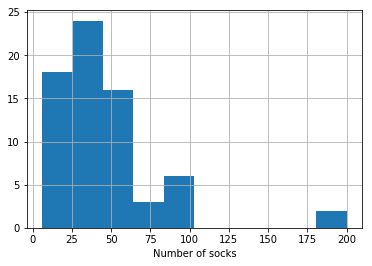

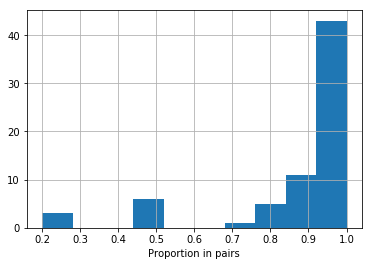

In [5]:
# Solution:

dfSocks = pd.read_csv("../../data/data_socks.csv")

# if we are more comfortable working with lists, just use that
n_socks_data = dfSocks["n_socks"].tolist()
prop_pairs_data = dfSocks["prop_pairs"].tolist()

dfSocks["n_socks"].hist()
plt.xlabel("Number of socks")
plt.show()

dfSocks["prop_pairs"].hist()
plt.xlabel('Proportion in pairs')
plt.show()

<br>

<a/ id='p3b'></a>

### (3b)  Revising our prior distributions

Decide on new parameters for our two prior distributions, to fit the data from our class.  You can also decide to use completely new prior distribution forms altogether if you would like.

Clearly state what your new prior distribution parameters are and how you chose them.  Show any relevant calculations.

Plot the same two-panel figure, but instead of the Karl Broman/blog post prior histograms, include our data along with your revised prior distributions.

In [6]:
# Solution

# prior for n_socks
prior_mu = np.mean(n_socks_data)
prior_sd = np.std(n_socks_data)
prior_size = -prior_mu**2 / (prior_mu - prior_sd**2)
prior_p = 1 - prior_mu**2 / (prior_size * prior_sd**2)

# prior for prop_pairs
prior_alpha = 18
prior_beta  = 1.3  # yields mean that matches np.mean(prop_pairs_data)

<br>

<a/ id='p3c'></a>

### (3c) Do your laundry!

**Now:** Suppose we draw 10 socks out of the laundry and there is one pair and 8 unique socks. Update your prior distributions based on these data.  Use the same **accept/reject likelihood function** form that we used in class. Use at least 10,000 iterations.

Provide a two-panel figure (two rows x one column):
1. Top panel is a histogram of samples from your prior distribution for `n_socks`
1. Bottom panel is a histogram of samples from the posterior distribution resulting from your accept/reject approximate Bayesian computation

Make sure the limits of your horizontal `n_socks`-axis are the same for both panels, to make for an easier comparison, and that all axes are labelled appropriately.

Note that the model `sock_model` from class is defined in the helper functions below.  It should not need modified, but if you want to modify it you can.

In [ ]:
# Solution:

unique_data = 8
pairs_data = 1

n_picked = 10     # The number of socks to pick out of the laundry
n_iter = 10000    # The number of iteration to run the sock-drawing simulation

results = []

for k in range(n_iter):
    
    # how many socks do we have? <-- This is a draw from the priors!
    n_socks = int(stats.nbinom.rvs(n=prior_size, p=prior_p, size=1))
    prop_pairs = float(stats.beta.rvs(a=prior_alpha, b=prior_beta, size=1))
    
    # run our model
    unique, pairs = sock_model(n_socks=n_socks, prop_pairs=prop_pairs, n_picked=n_picked)
        
    results.append([unique, pairs, n_socks, prop_pairs])

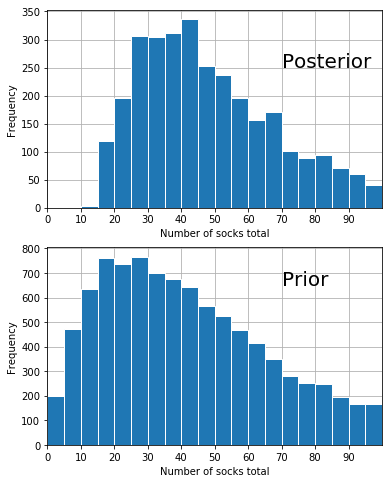

In [8]:
# generally, more efficient to convert/append to DataFrame just one time
# (timing test below, for the interested)
dfSocks = pd.DataFrame(results, columns=['unique', 'pairs', 'n_socks', 'prop_pairs'])

plt.subplots(nrows=2, ncols=1, figsize=(6,8))

plt.subplot(2,1,1)
ax = dfSocks["n_socks"].hist(bins=range(0,105,5), edgecolor="white")
ax.set_axisbelow(True)
plt.xlim([0, 100])
plt.xlabel('Number of socks total')
plt.xticks(range(0,100,10))
plt.ylabel('Frequency')
plt.text(70,650, 'Prior', size=20)

plt.subplot(2,1,2)
ax = dfSocks.loc[(dfSocks["unique"]==unique_data) & (dfSocks["pairs"]==pairs_data), "n_socks"].hist(
    bins=range(0,105,5), edgecolor="white")
ax.set_axisbelow(True)
plt.xlim([0, 100])
plt.xlabel('Number of socks total')
plt.xticks(range(0,100,10))
plt.ylabel('Frequency')
plt.text(70,250, 'Posterior', size=20)

plt.show()

Write a few sentences commenting on the effect of the Bayesian update of our prior distribution.

Save the samples from the prior distributions as lists or in a Pandas data frame. You will use them later.

<br>

<a/ id='p3d'></a>

### (3d) Do your laundry... again!

Now treat your resulting *posterior distributions* as the sample data from our class to develop ***updated prior distributions***.  The easiest way to do this is to assume the same functional form, but update the parameters of the distribution.

Clearly state what your updated prior distributions are and how you decided on these new distributions/parameters. Show any relevant calculations.

In [9]:
# Solution

# prior for n_socks
n_socks_data2 = dfSocks.loc[(dfSocks["unique"]==unique_data) & (dfSocks["pairs"]==pairs_data), "n_socks"].tolist()

prior_mu = np.mean(n_socks_data2)
prior_sd = np.std(n_socks_data2)
prior_size = -prior_mu**2 / (prior_mu - prior_sd**2)
prior_p = 1 - prior_mu**2 / (prior_size * prior_sd**2)

# prior for prop_pairs
prop_pairs_data2 = dfSocks.loc[(dfSocks["unique"]==unique_data) & (dfSocks["pairs"]==pairs_data), "prop_pairs"].tolist()

prior_alpha = 18
prior_beta  = 1.4  # yields mean that matches np.mean(prop_pairs_data2) (only changed a little)

Suppose you do your laundry a second time, again with all of your socks in there at once.  This time, you pull 12 socks out of the laundry and get 3 pairs and 6 distinct socks.

**Now:** Based on our updated prior distributions, use the accept/reject likelihood function with these new data to update your priors a second time. Again, use at least 10,000 iterations.

Provide a three-panel figure (three rows x one column):
1. First two panels are the same as in **3c**
1. Third (bottom) panel is the posterior distribution resulting from the second update

So the top panel is only the prior distribution (no data), the middle panel is a posterior updated once with data and the bottom panel is a posterior distribution updated with two sets of data.

Each update with data is called an **assimilation step** - we are assimilating laundry data.

In [10]:
# Solution:

unique_data = 6
pairs_data = 3

n_picked = 12     # The number of socks to pick out of the laundry
n_iter = 10000    # The number of iteration to run the sock-drawing simulation

results = []

for k in range(n_iter):
    
    # how many socks do we have? <-- This is a draw from the priors!
    n_socks = int(stats.nbinom.rvs(n=prior_size, p=prior_p, size=1))
    prop_pairs = float(stats.beta.rvs(a=prior_alpha, b=prior_beta, size=1))
    
    # run our model
    unique, pairs = sock_model(n_socks=n_socks, prop_pairs=prop_pairs, n_picked=n_picked)
        
    results.append([unique, pairs, n_socks, prop_pairs])    

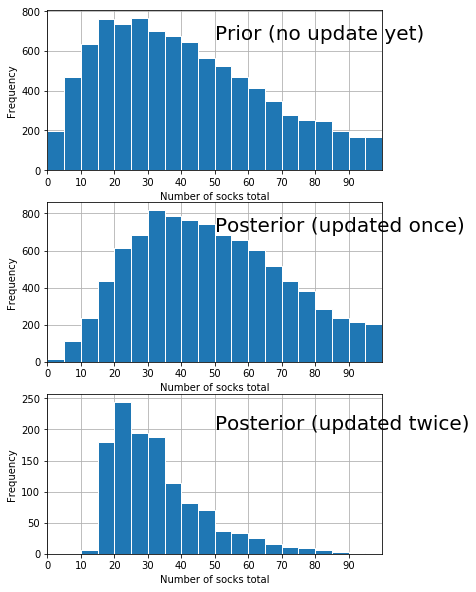

In [23]:
    
# generally, more efficient to convert/append to DataFrame just one time
# (timing test below, for the interested)
dfSocks2 = pd.DataFrame(results, columns=['unique', 'pairs', 'n_socks', 'prop_pairs'])

plt.subplots(nrows=3, ncols=1, figsize=(6,10))

plt.subplot(3,1,1)
ax = dfSocks["n_socks"].hist(bins=range(0,105,5), edgecolor="white")
ax.set_axisbelow(True)
plt.xlim([0, 100])
plt.xlabel('Number of socks total')
plt.xticks(range(0,100,10))
plt.ylabel('Frequency')
plt.text(50,660, 'Prior (no update yet)', size=20)

plt.subplot(3,1,2)
ax = dfSocks2["n_socks"].hist(bins=range(0,105,5), edgecolor="white")
ax.set_axisbelow(True)
plt.xlim([0, 100])
plt.xlabel('Number of socks total')
plt.xticks(range(0,100,10))
plt.ylabel('Frequency')
plt.text(50,700, 'Posterior (updated once)', size=20)

plt.subplot(3,1,3)
ax = dfSocks2.loc[(dfSocks2["unique"]==unique_data) & (dfSocks2["pairs"]==pairs_data), "n_socks"].hist(
    bins=range(0,105,5), edgecolor="white")
ax.set_axisbelow(True)
plt.xlim([0, 100])
plt.xlabel('Number of socks total')
plt.xticks(range(0,100,10))
plt.ylabel('Frequency')
plt.text(50,200, 'Posterior (updated twice)', size=20)

plt.show()

<br>

<a/ id='p3e'></a>

### (3e) Some calculations

Calculate the 5-95% quantile range for `n_socks` using each of: (1) the prior distribution, (2) the posterior distribution after one update, and (3) the posterior distribution after two updates.  These are called the 90% **credible intervals** in this Bayesian setting, in contrast to the frequentist confidence interval.

In [16]:
# Solution:

print(dfSocks["n_socks"].quantile([0.05, .95]))
print(dfSocks.loc[(dfSocks["unique"]==8) & (dfSocks["pairs"]==1), "n_socks"].quantile([0.05, .95]))
print(dfSocks2.loc[(dfSocks2["unique"]==6) & (dfSocks2["pairs"]==3), "n_socks"].quantile([0.05, .95]))

0.05      8.0
0.95    112.0
Name: n_socks, dtype: float64
0.05     21.0
0.95    106.0
Name: n_socks, dtype: float64
0.05    16.0
0.95    62.0
Name: n_socks, dtype: float64


Write a few sentences commenting on similarities/differences between your original prior distribution (for the class data set), and the two updated posterior distributions, as well as the differences in the estimated credible intervals. Explain why the distributions/credible intervals are changing as they are, as more data are assimilated.

<br>

**Concluding note:** This only is technically accurate estimation if we assume that all of your socks are in the laundry at the same time. Or if we revise our prior distributions to estimate the number of socks we have in the laundry in any given load. But that's way harder to pin down.

<br><br><br>

<a id='helpers'></a>

---

[Back to top](#top)

## Some things that might be useful

Easiest way to start:  Click this cell, go to "Cell" in the toolbar above, and click "Run All Below"

In [1]:
import pandas as pd
import numpy as np
import copy as cp
from scipy import stats
from math import floor
import matplotlib.pyplot as plt
import unittest
import csv
from time import time

## Definitely useful

In [3]:
def slr(alpha, Teq, temperature):
    '''sea-level emulator of Rahmstorf 2007 (DOI: 10.1126/science.1135456)
    Takes global mean temperature as forcing, and parameters:
    alpha = temperature sensitivity of sea level rise, and
    Teq   = equilibrium temperature,
    and calculates a rise/fall in sea levels, based on whether the temperature
    is warmer/cooler than the equilibrium temperature Teq.
    Here, we are only worrying about alpha (for now!)'''

    n_time = len(temperature)
    deltat = 1
    sealevel = [0]*n_time
    sealevel[0] = -134
    for t in range(n_time-1):
        sealevel[t+1] = sealevel[t] + deltat*alpha*(temperature[t]-Teq)

    return sealevel


def sock_model(n_socks, prop_pairs, n_picked):
    
    n_pairs = int( floor(n_socks/2) * prop_pairs)
    n_odd = n_socks - 2*n_pairs

    # label all our socks
    socks = []
    for i in range(n_pairs):
        socks = socks + [i]*2
    for j in range(n_pairs, n_pairs+n_odd):
        socks = socks + [j]

    if len(socks)>0:
        # pick our socks out of the dryer
        picked_socks = list(np.random.choice(socks, size=min(n_picked, n_socks), replace=False))
        sock_counts = [picked_socks.count(k) for k in range(max(socks)+1)]

        # how many were singleton socks?
        unique = sock_counts.count(1)

        # how many were in pairs?
        pairs = sock_counts.count(2)
        
    else:
        unique = 0
        pairs = 0
    
    return unique, pairs


[Back to top](#top)